# Predicting Education Level

## Introduction

At some point in our lives we must decide on how to make a living. People wish to find a path that leads to the most success without using too many resources, and one of the main problems to that is education. The decision to pursue a higher education is both time and money-consuming, which is why our Data Science project question is: "Can we predict the highest level of education someone has received based on their salary, years of experience, and age?"

The dataset we are using contains 7 columns reading left to right: `Education`, `Experience`, `Location`, `Job_Title`, `Age`, `Gender`, `Salary`, where each row represents an individual worker.

- `Education`: four categories representing the highest level of education received: High School, Bachelor, Master, PhD
- `Experience`: years of professional experience
- `Location`: three locations of work: Urban, Suburban, Rural
- `Job_Title`: four general job titles: Manager, Director, Analyst, Engineer
- `Age`: age
- `Gender`: Female or Male
- `Salary`: annual salary

## Data analysis

- Demonstrate that the dataset can be read from the web into R

We found the dataset on Kaggle. We were able to download it into the project folder as a `.csv` file. After that, we are able to use the `read_csv` function to read it into a data frame to then work with in `R`. The name of the file is "`salary_prediction_data.csv`" and it's stored in the `data` folder.

In [7]:
# Load in the libraries needed to read the csv file
library(tidyverse)

In [8]:
# Load the csv file into a data frame
# Dataset website: https://www.kaggle.com/datasets/mrsimple07/salary-prediction-data
download.file("https://raw.githubusercontent.com/WhenLifeHandsYouLemons/UBC-DSCI-100-Project/main/data/salary_prediction_data.csv", "data/salary_prediction_data.csv")

df_untidy <- read_csv("data/salary_prediction_data.csv")
head(df_untidy)

Rows: 1000 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, Location, Job_Title, Gender
dbl (3): Experience, Age, Salary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,Experience,Location,Job_Title,Age,Gender,Salary
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
High School,8,Urban,Manager,63,Male,84620.05
PhD,11,Suburban,Director,59,Male,142591.26
Bachelor,28,Suburban,Manager,61,Female,97800.26
High School,29,Rural,Director,45,Male,96834.67
PhD,25,Urban,Analyst,26,Female,132157.79
PhD,19,Rural,Director,27,Female,156312.94


- Clean and wrangle your data into a tidy format

Our dataset is already close to being tidy, but there are a few improvements we could do to make it better. We could change all the predictor names to be lowercase and include the units that it is in. Looking at the salary column (in our original `csv` file), we can see the values are all not rounded to 2 decimal places. We also need to remove the Location, Job_Title, and Gender columns because those are not going to be used as predictors in our analysis.

In [74]:
# Rename all the columns to include the units and be in lowercase
# Then select the newly mutated columns only
df_tidy <- df_untidy |>
    mutate(education = Education, experience_years = Experience, salary_dollars = Salary) |>
    select(education, experience_years, salary_dollars) |>
    mutate(salary_dollars = round(salary_dollars, 2)) |>
    mutate(education = as_factor(education))

head(df_tidy)

education,experience_years,salary_dollars
<fct>,<dbl>,<dbl>
High School,8,84620.05
PhD,11,142591.26
Bachelor,28,97800.26
High School,29,96834.67
PhD,25,132157.79
PhD,19,156312.94


- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.

In [75]:
# Load library for spliting data into training and testing
library(tidymodels)

In [80]:
# Set the seed for this code cell
set.seed(1)

# Split data into a rough 75-25 split
df_split <- initial_split(df_tidy, 0.75, education)
df_train <- training(df_split)
df_testing <- testing(df_split)

# Summarise the average values for each of our predictor classes
df_summary_1 <- df_train |>
    summarise(average_experience_years = round(mean(experience_years, na.rm=TRUE)),
              # average_age_years = round(mean(age_years, na.rm=TRUE)),
              average_salary_dollars = round(mean(salary_dollars, na.rm=TRUE), 2))

# Summarise the total observations in each predictor class
df_summary_2 <- df_train |>
    summarise(total_observations = length(experience_years))

# There are no observations with missing data.

# Print them out
print(df_split)
head(df_summary_1)
head(df_summary_2)

<Training/Testing/Total>
<748/252/1000>


average_experience_years,average_salary_dollars
<dbl>,<dbl>
15,105281.4


total_observations
<int>
748


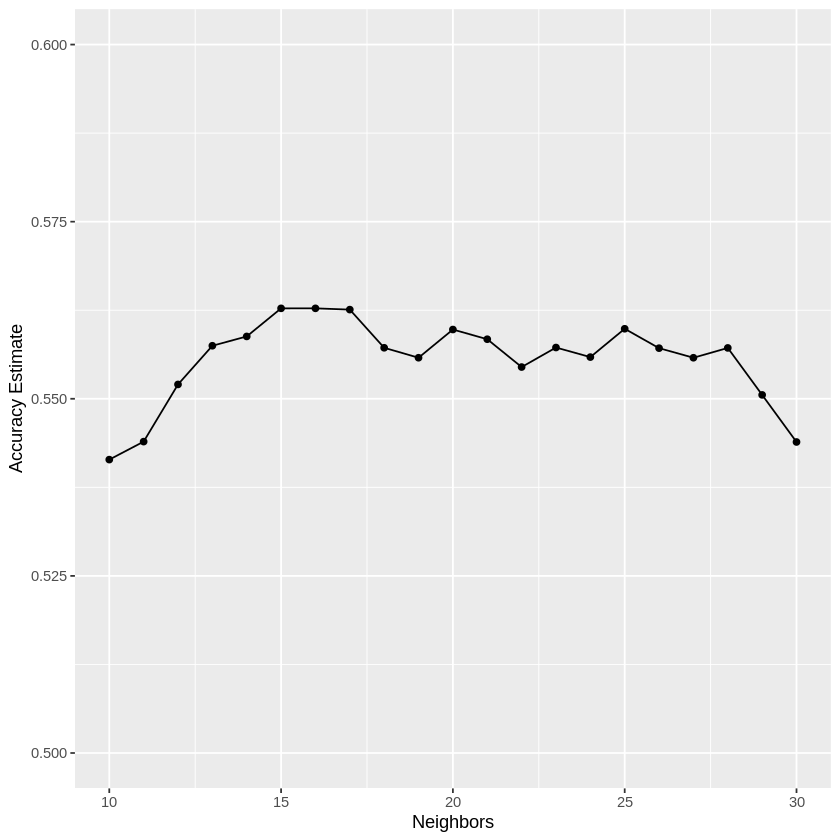

In [86]:
# Set the seed for this code cell
set.seed(1)

# Create model specs
salary_vfold <- vfold_cv(df_train, v = 10, strata = education)

salary_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create recipe
salary_recipe <- recipe(education ~ ., data = df_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# salary_prepped <- salary_recipe |>
#     prep() |>
#     bake(df_train)

# vis <- ggplot(salary_prepped, aes(x=salary_dollars, y=experience_years)) +
#     geom_point(aes(color=education))

# vis

k_vals <- tibble(neighbors = seq(10, 30, by = 1))

results_workflow <- workflow() |>
    add_recipe(salary_recipe) |>
    add_model(salary_spec) |>
    tune_grid(resamples = salary_vfold, grid = k_vals) |>
    collect_metrics()

# salary_fit <- workflow() |>
#     add_recipe(salary_recipe) |>
#     add_model(salary_spec) |>
#     fit_resamples(resamples = salary_vfold) |>
#     collect_metrics()

# salary_fit

accuracies <- results_workflow |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
      # scale_y_continuous(limits = c(0.5, 0.6)) # adjusting the y-axis

cross_val_plot

In [101]:
salary_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

salary_fit <- workflow() |>
    add_recipe(salary_recipe) |>
    add_model(salary_spec_2) |>
    fit(df_train)

salary_preds <- salary_fit |>
    predict(df_testing) |>
    bind_cols(df_testing)

salary_metrics <- salary_preds |>
    metrics(truth = education, estimate = .pred_class) |>
    filter(.metric == "accuracy")

salary_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5674603


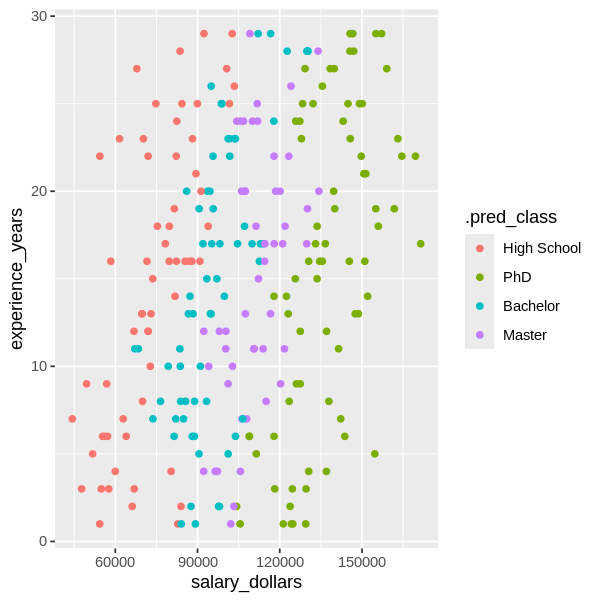

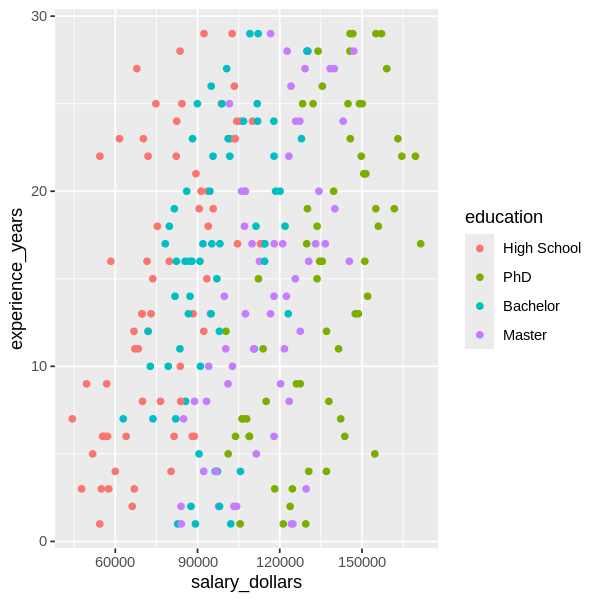

In [104]:
options(repr.plot.height = 5, repr.plot.width = 5)

pred_vis <- ggplot(salary_preds, aes(x=salary_dollars, y=experience_years)) +
    geom_point(aes(color=.pred_class))

truth_vis <- ggplot(salary_preds, aes(x=salary_dollars, y=experience_years)) +
    geom_point(aes(color=education))

pred_vis
truth_vis

- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [79]:
df_plot <- df_train |>
    ggplot(aes(x = age_years, y = salary_dollars, color = education)) +
    geom_point() +
    labs(x = "Age (years)", y = "Salary ($)", color = "Education Level")

df_plot

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'age_years' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_hand

## Analysis

In [7]:
print("Type here")

[1] "Type here"


## Methods

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

## Expected outcomes and significance

We expect to find that higher numbers in all predictor fields (salary, years of work experience, and age) predict a higher level of education.

We wish to use our findings to help someone determine what education level, years of experience, and age they should be in order to reach a certain salary range. These results may impact the way people choose to allocate the years of their life, and hopefully help them reach a decision in a less ambiguous way.

This analysis could lead to future questions about whether or not people should be spending their time and money on higher education in order to reach their desired financial position.